<a href="https://colab.research.google.com/github/MJMortensonWarwick/AI-DL/blob/main/0_3-bayesian_statistics_and_ml_p3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 0_3-bayesian_statistics_and_ml_p3

Carrying on from our previous Notebook, we apply the Bayesian approach to a standard ML approach ... the linear regression. Ultimately both a frequentist and a Bayesian implementation have the same core goal in an ML framework - to build a model to estimate an unseen target value 
($y$) from a set of features ($X$) - and most of elements of the workflow involved will remain the same. The key difference is in how they achieve this (i.e. the models).

The frequentist interpretation of linear regression is given by the following formula:<br><br>
$Y = \alpha + \beta X + e$<br><br>
... that is to say that given some set of $X$ values we can learn some parameters $\alpha$ and $\beta$ (one $\beta$ value for each feature/$X$) that can predict a corresponding taget value ($Y$), subject to some error ($e$). Our goal is find values for these parameters that minimise error at prediction time.

Let's compare this with the Bayesian interpretation:<br><br>
$Y = N(\beta X + \sigma^2)$<br><br>
In this representation we consider $Y$ to be a normal distribution (our posterior) with $\mu = \beta X$ and some standard deviation ($\sigma^2$). We can think of $\sigma^2$ as basically the error term in the frequentist version .... that is that our line is fit to the values of $\alpha + \beta X$ and any gap between the line and the datapoints are the $\sigma^2$ of the model.

Further to this, while the values of $\alpha$ and $\beta$ are fixed values (point estimates) in the frequentist framework, for a Bayesian they are just parameters from an unknown distribution. Rather than finalising on a single value for each, instead we create a distribution of likely values each could take which, being a Gaussian distribution, will have a higher probability density around the mean ($\mu$). 

At predcition we could use the mean of each parameter's distribution (i.e. the posterior distibutions for $\alpha$ and $\beta$) to make a single prediction - thus building a model that is a close approximation of the one a frequentist would build (at prediction time at least), but more likely we will make multiple predictions drawing samples from the distributions of each parameter. These multiple predictions can then be averaged to produce a single estimate for $Y$. In many ways we can consider the Bayesian approach, if executed in this fashion, as an ensemble model where we effectively build multiple models at prediction time by drawing different values for each paramter based on the probability densities created. 

If this has all got a bit complicated, let's simplify as the following:
1. In a Bayesian model we don't treat our parameters as single values and instead create a probability distribution for each. In linear regression this means a probability distribution for $\alpha$ and for each $\beta$.
2. Rather than treating error as an simply a by product, we explicity model error as another parameter ($\sigma^2$), and therefore as another probability distribution.
3. We learn the model by finding good distributions for each parameter using MCMC sampling (previous Notebook). 
4. Rather than creating a single estimate for $Y$ we in fact create a probability distribution (the model's posterior) with multiple potential values, but with a probability mass centred around the mean of the distribution ($\mu$).
5. At prediction time the model works like an ensemble by making multiple predictions of the target ($Y$) using different parameters drawn from each parameter's posterior distribution. Our predictions can then be averaged to make a final prediction.

Let's see it in action!


In [116]:
from sklearn.datasets import make_regression

data = make_regression(500, n_features=3, n_informative=2, random_state=123)
data

(array([[-0.52626402, -0.51835321,  1.20251659],
        [ 1.71604032,  1.30819356, -0.98502358],
        [-0.66477925, -0.35561313, -0.80157178],
        ...,
        [-0.82200042,  1.60708495,  0.73782539],
        [ 1.8368685 , -0.71840316,  1.13494469],
        [ 0.51788663,  0.95798994, -1.20962774]]),
 array([-6.24881616e+01,  1.81007528e+02, -6.11175858e+01,  3.39871952e+01,
        -1.20939542e+01, -6.91431475e+01,  9.14822880e+01,  3.26423023e+00,
         6.21147967e+01, -6.32893051e+01, -6.72842958e+01,  1.38968464e+02,
         1.29904693e+02, -8.60733616e+00, -6.29472188e+01, -2.27375369e+01,
        -1.28416575e+01,  3.21464671e+01, -3.34263591e+01,  3.41308631e+01,
        -1.63749365e+01, -1.37065633e+02, -3.24150678e+01,  1.54090484e+01,
         5.31577960e+01,  2.69161855e+01,  8.10849096e+01,  2.38699864e+01,
         3.08817246e+01,  6.90997600e+01, -1.32606659e+01, -6.49139835e+01,
        -4.56032218e+01, -5.30722600e+01,  1.37772139e+02,  8.13873164e+01,
       

In [117]:
X = data[0]
y = data[1]

from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X = scaler.fit_transform(X)

from sklearn.model_selection import train_test_split

X_train, X_test, Y_train, Y_test = train_test_split(X, y, test_size=0.2)
print(X_train.shape)
print(X_test.shape)
print(Y_train.shape)
print(Y_test.shape)

(400, 3)
(100, 3)
(400,)
(100,)


To this point we haven't done anything we haven't before. We've created a dataset of three features, two of which are informative (explain $Y$) and the other not, and a set of target values. We've split these into training and test (80/20).

In [118]:
import pymc3 as pm
import arviz as az

with pm.Model() as bayes_LR:
    a = pm.Normal('intercept', 0, 1)
    b0 = pm.Normal('coeff0', 0, 1)
    b1 = pm.Normal('coeff1', 0, 1)
    b2 = pm.Normal('coeff2', 0, 1)
    s = pm.Exponential('error', 0.01)
    
    x0_ = pm.Data('features0', X_train[:, 0])
    x1_ = pm.Data('features1', X_train[:, 1])
    x2_ = pm.Data('features2', X_train[:, 2])
    
    obs = pm.Normal('observation', a + b0*x0_ + b1*x1_ + b2*x2_, s, observed=Y_train)
    
    trace = pm.sample(5000, init="adapt_diag", random_seed=123, return_inferencedata=True)

Auto-assigning NUTS sampler...
Initializing NUTS using adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [error, coeff2, coeff1, coeff0, intercept]


Sampling 2 chains for 1_000 tune and 5_000 draw iterations (2_000 + 10_000 draws total) took 13 seconds.


Here we have specified our model. Much of this is as with the previous Notebook but obviously updated to our linear regression problem. We have specified $\alpha$ and $\beta$ as non-informative Gaussian distributions (with $\mu=0$ and $\sigma^2$ = 1). 

For the error (s) we have used an exponential distribution. Error ($\sigma^2$) must be a positive value (negative error makes no sense) so we need a distribution that only allows this. The exponential fits that bill, although other contenders would be the gamma or a half-normal. The exponential takes a single parameter ($\lambda$) which determines the length of the tail. A lower value, as we have chosen, suggests a low amount of error (wishful thinking maybe).

After this we have split our features into three separate data containers (_pm.Data_). This allows us to later replace the data in the containers with our test data to make predictions.

Finally, we model $Y$ as a Gaussian with the regression formula as $\mu$ and our error variable as $\sigma^2$. We also pass the generated data as 'observed' (same as with the work in the previous Notebook).

Once the model is fit, again using _pm.Sample_ as we did previously, we can inspect the posteriors:

Summary DF
             mean     sd  hdi_3%  hdi_97%  ...  mcse_sd  ess_bulk  ess_tail  r_hat
intercept  -0.236  0.969  -2.093    1.551  ...    0.009   16576.0    7899.0    1.0
coeff0      3.547  1.002   1.677    5.456  ...    0.006   15546.0    8305.0    1.0
coeff1      3.804  1.023   1.901    5.718  ...    0.006   16851.0    8369.0    1.0
coeff2     -0.068  0.973  -1.931    1.687  ...    0.010   17187.0    7923.0    1.0
error      77.923  2.981  72.258   83.318  ...    0.018   14560.0    7851.0    1.0

[5 rows x 9 columns]


HDI
[[<matplotlib.axes._subplots.AxesSubplot object at 0x7f42aba11110>


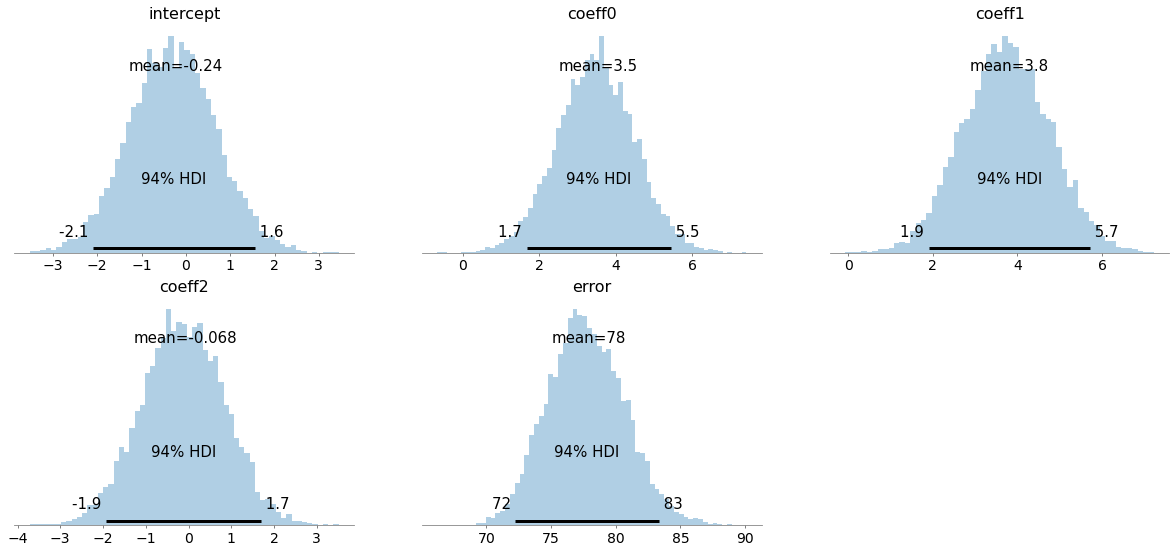

In [119]:
with bayes_LR:
    print("Summary DF")
    print(az.summary(trace))
    print("\n")
    print("HDI")
    print(az.plot_posterior(trace, kind="hist"));

These outputs are the same as we saw previously, just there are more of them as we have a lot more distributions to estimate. Again our model has good $\hat{R}$ values and no obvious problems. We have mean estimates for each of our $\alpha$ and $\beta$ parameters - and our model has recognised that $\beta{2}$ is the non-informative feature. However, we do have relatively high error at 78.

With the model specified / parameters learned, we can start predicting:

In [120]:
with bayes_LR:
    pm.set_data({'features0': X_test[:, 0], 'features1': X_test[:, 1], 'features2': X_test[:, 2]})
    posterior = pm.sample_posterior_predictive(trace);

Here we return to our model and update the data containers with the values in _X\_test._ After this we can use our posterior in predictive mode.

In [121]:
import pandas as pd

y_hat = posterior['observation']
y_pred = pd.DataFrame(y_hat).transpose()
y_pred.head(10)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,9960,9961,9962,9963,9964,9965,9966,9967,9968,9969,9970,9971,9972,9973,9974,9975,9976,9977,9978,9979,9980,9981,9982,9983,9984,9985,9986,9987,9988,9989,9990,9991,9992,9993,9994,9995,9996,9997,9998,9999
0,86.951082,39.152164,-9.986481,20.671176,-1.825464,-8.816120,-15.424372,-84.103812,-72.033517,46.568079,173.271856,7.968157,96.821936,-116.453429,19.240685,136.744747,-99.484995,63.380050,-56.907310,112.671756,46.505364,-182.392722,103.869280,55.629408,-50.264240,38.575106,58.359560,43.670946,22.219815,-89.972569,16.005526,-26.020476,65.405906,37.180241,74.548106,-23.679363,-2.895140,83.534808,115.631440,8.883037,...,-14.294586,89.484977,-4.005554,19.207766,-6.597589,8.091113,-130.282109,37.320524,-33.876414,-86.336279,-9.598458,-97.936195,202.568570,-1.422769,171.340466,-107.231814,-103.876028,-5.505625,46.232050,54.195560,20.436063,-41.901773,82.630455,-34.622071,113.993285,-6.789551,-23.542967,-39.492406,6.837865,-126.388794,-50.980838,1.115539,-100.588648,20.420701,-146.017679,98.386377,-159.732982,5.911875,-63.075270,-79.674347
1,-22.435922,-3.118193,39.787944,11.686384,-108.718940,2.766818,74.281634,77.331908,-25.888756,3.304350,1.529464,-95.957708,-27.958410,-30.757972,-43.647388,77.434757,-11.476108,30.949797,-26.743545,-74.346504,0.052331,-41.530701,98.136959,-104.720866,-57.933660,77.097509,-142.174077,110.647930,150.823058,-28.328657,-83.121166,-106.855395,3.683325,13.087833,96.840662,25.427158,-5.988748,-99.032344,-50.585667,-61.303984,...,-74.046886,9.992971,-24.911028,5.397470,-34.190156,103.496216,-61.316853,29.440951,148.274272,0.226006,-25.302441,53.071334,5.863301,19.313057,21.267724,44.364528,-25.484596,-60.946749,-17.537999,44.240232,120.775765,-64.850149,-30.670810,-160.760731,-66.253806,44.552610,23.483808,127.698017,107.329744,49.233148,29.792627,-123.270249,-98.641953,232.911406,109.978734,-22.804942,29.643301,-43.226838,-26.678327,125.744464
2,-65.928511,142.246495,62.008669,-21.813129,4.079857,28.835882,66.245416,-164.314398,-127.170496,42.865538,62.965615,47.976078,65.193096,-58.973150,-145.225495,-15.942137,-58.337075,51.796914,-24.045191,33.892072,22.390421,-68.807696,14.843148,40.886470,131.212954,-12.331582,-19.768530,45.471819,-13.594880,-73.389334,-52.258588,138.976886,121.040197,-50.709979,14.324429,42.617934,19.704208,11.589301,83.577993,55.458648,...,45.833890,42.791681,111.739686,-22.533261,159.288896,84.647199,16.007372,72.557688,68.763898,-15.418685,-154.107656,-15.522503,-75.012822,25.246690,2.844829,-25.185230,32.277497,24.860216,-64.399372,30.607624,103.637020,87.821404,-50.903312,-43.045970,-44.062922,65.546985,-61.127380,138.602610,48.292514,-29.036748,-21.827462,11.633651,-65.052843,-86.008025,-73.536140,-28.374634,-35.807447,69.209351,-44.235956,-43.291543
3,84.597194,-5.691887,42.632416,-71.368526,-47.065162,-67.027948,85.842124,-6.948802,78.191041,-44.794964,-32.302380,-17.044485,70.857270,-99.212086,-2.634619,19.051429,127.882863,8.735651,-18.423271,40.266893,152.034210,-15.190264,-97.719542,-81.179945,-36.157166,70.597695,132.372014,59.355073,51.028951,88.004761,86.156734,-8.705696,30.476495,-129.489700,109.533105,-105.838793,7.635548,111.525819,33.205028,-28.217317,...,66.624270,-65.597733,-109.411311,120.517200,55.108770,104.643754,-72.217756,-83.934220,51.972095,-65.662899,-83.094551,22.307375,-29.060306,58.851116,-104.075728,-19.259689,-49.265099,-75.857009,21.708366,-46.995575,17.673681,120.264607,-24.172480,74.909356,21.125224,46.989736,-123.483443,3.759074,-51.044545,19.242890,-66.996865,101.697968,-193.310094,2.068892,-39.966041,43.231290,51.178061,71.953125,-24.028957,-19.073963
4,-69.265443,-28.738839,-53.337498,47.984365,2.602569,218.781628,115.151455,-119.112388,140.185939,-54.619508,19.173660,25.506871,-53.343680,-94.603713,-38.400632,13.213096,44.890479,3.674956,-65.216808,-81.872490,-58.031618,-28.390343,-18.295745,-39.716541,-65.925999,56.650347,-61.71

This code should be fairly self-explanatory. We add the generated predictions into a dataframe. Our dataframe is 100 rows (although we print only 10), representing one row per item in _X\_test_, and 10,000 columns representing 10,000 predictions for each item. Each cell in the DataFrame represents an individual prediction such that the $j$th column of the $i$th row represents our prediciton for $Y_{ij}$.

In [122]:
y_pred["Pred"] = y_hat.mean(axis=0)
y_pred["PredSD"] = y_hat.std(axis=0)
y_pred["Real"] = Y_test
y_pred["SE"] = (y_pred["Real"] - y_pred["Pred"]) **2
y_pred[["Real", "Pred", "PredSD", "SE"]].head(10)

,Real,Pred,PredSD,SE
0,47.142421,1.530480,78.107755,2080.449166
1,113.194711,6.705805,78.064788,11339.887131
2,105.374639,6.220454,78.747104,9831.552328
3,82.973318,4.953433,77.103634,6087.102459
4,60.587798,5.017082,77.611588,3088.104462
5,-32.185166,-2.890593,78.595847,858.171978
6,29.783622,2.892464,78.031130,723.134379
7,-45.880933,-2.972269,78.156095,1841.153375
8,19.447141,1.589793,78.401256,318.884875
9,-22.246865,-1.577693,77.373820,427.214705


Here we have added some extra columns to our DataFrame. The first finds the average of each prediction (the $Y$ value our predictor should output) and the second the standard deviation of that prediction. We then merge in the real _Y\_test_ values and finally computer the squared distance between prediction and real value.

With these metrics calculated we can get the RMSE for our model:

In [123]:
import math

rmse = math.sqrt(y_pred.SE.mean())
print(f'RMSE (Bayesian model) = {round(rmse, 4)}')

RMSE (Bayesian model) = 80.4466


As before, this is not necessarily great. We have a lot of parameters to estimate but not a lot of data. Let's see how a frequentist model would do:

In [124]:
from sklearn.linear_model import LinearRegression
import numpy as np

lin_model = LinearRegression()

# fit the model to the training data
lin_model_fit = lin_model.fit(X_train, Y_train)

# print the beta values of the model (co-efficients)
betas = lin_model_fit.coef_
counter = 0
for col in [0,1,2]:
    if counter == 0:
        print("Intercept/co-efficients")
        print("-----------------------------------------")
        print(f'Intercept: {round(lin_model_fit.intercept_, 4)}')
    print(f'{col}: {round(betas[counter], 4)}')
    counter +=1

# predict the data
lin_model_predict = lin_model_fit.predict(X_test)

# calculate RMSE (root mean square error) and R^2 (predictive power)
from sklearn.metrics import mean_squared_error, r2_score
rmse2 = (np.sqrt(mean_squared_error(Y_test, lin_model_predict)))
print(f'RMSE (GLM model) = {round(rmse2, 4)}')

Intercept/co-efficients
-----------------------------------------
Intercept: -1.1065
0: 54.8777
1: 60.7418
2: 0.0
RMSE (GLM model) = 0.0


We can say the frequentist approaches performs much better for this size of dataset with a RMSE close to zero. We also may see it found slightly larger values for $\beta0$ and $\beta1$. 

However, we could potentially use these values to update our model. Earlier we used an uninformative prior ($\mu=0$ and $\sigma^2=1$) as we had no knowledge on what these values should be. In other cases we may have been able to have used subject matter expertise to set these - i.e. asking the expected impact of each feature - but given this is random data such things don't exist. However, now with information from our frequentist friends we can try our model again with these values as a prior:

Auto-assigning NUTS sampler...
Initializing NUTS using adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [error, coeff2, coeff1, coeff0, intercept]


Sampling 2 chains for 1_000 tune and 2_000 draw iterations (2_000 + 4_000 draws total) took 9 seconds.


Summary DF
             mean     sd  hdi_3%  hdi_97%  ...  mcse_sd  ess_bulk  ess_tail  r_hat
intercept  -1.010  0.010  -1.028   -0.992  ...      0.0    6020.0    3212.0    1.0
coeff0     54.991  0.010  54.973   55.009  ...      0.0    5129.0    3214.0    1.0
coeff1     60.055  0.010  60.036   60.075  ...      0.0    4755.0    3135.0    1.0
coeff2      0.002  0.010  -0.017    0.019  ...      0.0    5176.0    3381.0    1.0
error       0.707  0.027   0.657    0.760  ...      0.0    5648.0    3157.0    1.0

[5 rows x 9 columns]


HDI
[[<matplotlib.axes._subplots.AxesSubplot object at 0x7f42afcc8e50>


RMSE (Bayesian model) = 0.672


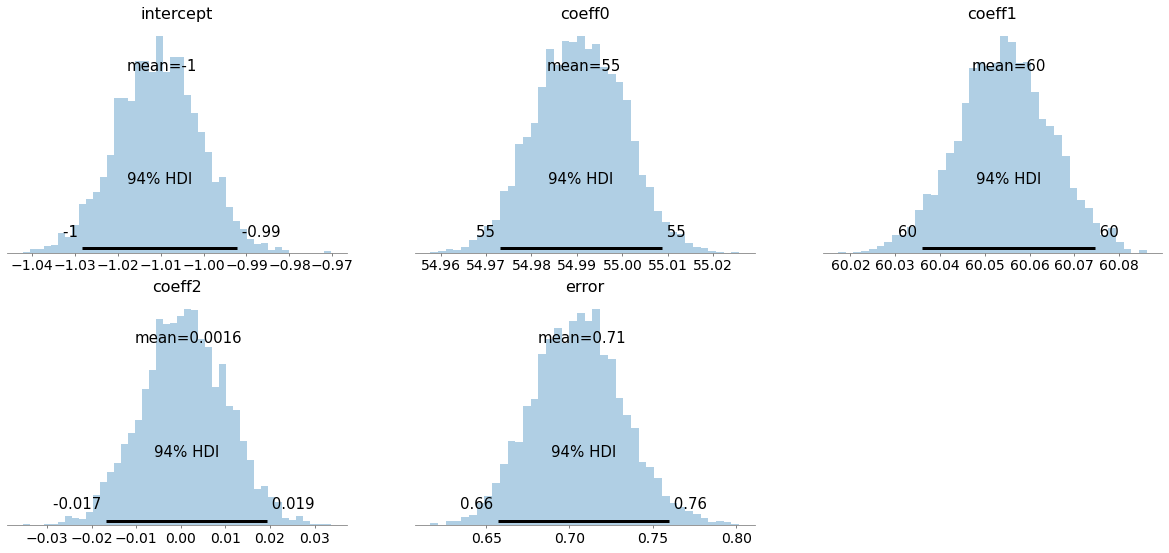

In [127]:
with pm.Model() as bayes_LR:
    a = pm.Normal('intercept', -1, 0.01)
    b0 = pm.Normal('coeff0', 55, 0.01)
    b1 = pm.Normal('coeff1', 60, 0.01)
    b2 = pm.Normal('coeff2', 0, 0.01)
    s = pm.Exponential('error', 0.01)
    
    x0_ = pm.Data('features0', X_train[:, 0])
    x1_ = pm.Data('features1', X_train[:, 1])
    x2_ = pm.Data('features2', X_train[:, 2])
    
    obs = pm.Normal('observation', a + b0*x0_ + b1*x1_ + b2*x2_, s, observed=Y_train)
    
    trace = pm.sample(2000, init="adapt_diag", random_seed=123, return_inferencedata=True)

    print("Summary DF")
    print(az.summary(trace))
    print("\n")
    print("HDI")
    print(az.plot_posterior(trace, kind="hist"))

    pm.set_data({'features0': X_test[:, 0], 'features1': X_test[:, 1], 'features2': X_test[:, 2]})
    posterior = pm.sample_posterior_predictive(trace);

y_hat = posterior['observation']
y_pred = pd.DataFrame(y_hat).transpose()

y_pred["Pred"] = y_hat.mean(axis=0)
y_pred["PredSD"] = y_hat.std(axis=0)
y_pred["Real"] = Y_test
y_pred["SE"] = (y_pred["Real"] - y_pred["Pred"]) **2

rmse = math.sqrt(y_pred.SE.mean())
print(f'RMSE (Bayesian model) = {round(rmse, 4)}')

As can be seen, we now have very comparable models and performance, but with the extra beenfit of having an estimation of our confidence in the values and an ability to make ensemble predictions. Of course we could achieve the same thing with more data (as we have a lot of parameters to estiamte) but this is more to illustrate the approach

##TL;DR
We have seen a Bayesian implementation of linear regression and some of the benefits it can bring. This gives us some insight to how a deep learning model may use Bayesian approaches ... the key element is that each parameter is now modelled as a distribution and predictions are made in an ensemble fashion.